# Calculation of energies

In [2]:
# %%
import sys
import plot_tools as pt
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib as mpl
import numpy as np
from skimage import measure

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
import scipy.interpolate as si
from matplotlib.colors import LightSource
import oommfpy.tools as ot

from pathlib import Path
import glob

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
import fidimag as fd
from fidimag.common import CuboidMesh
from fidimag.atomistic import Sim

# Simulation

In [4]:
FIELD = 100
nx, ny, nz = 30, 30, 30
dx, dy, dz = 1, 1, 1
mesh = CuboidMesh(nx=nx, ny=ny, nz=nz,
                  dx=dx, dy=dy, dz=dz,
                  x0=-nx * 0.5, y0=-ny * 0.5, z0=-nz * 0.5,
                  unit_length=1.,
                  periodicity=(True, True, False)
                  )

sim_name = 'sk_helix'
sim = Sim(mesh, name=sim_name, integrator='sundials_openmp')

sim.mu_s = 1
sim.add(fd.atomistic.Exchange(1))
sim.add(fd.atomistic.DMI(0.727, dmi_type='bulk'))
bz_min = FIELD
sim.add(fd.atomistic.Zeeman((0.0, 0.0, bz_min * 1e-3)), save_field=True)
kc = -0.05
if np.abs(kc) > 0.0:
    sim.add(fd.atomistic.CubicAnisotropy(kc))

Number of threads (CVODE) = 8


In [5]:
x, y, z = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
xs, ys, zs = np.unique(x), np.unique(y), np.unique(z)

# Find the energy from equilibrium states

Load the `npy` files into the Fidimag simulation object and compute the energy of the configurations. We save the energies in dictionaries.

In [21]:
# Total energy:
data = {}
# Zeeman energy:
data_zeeman = {}
# Dmi energy:
data_dmi = {}

for state in ['saturated', 'one_dim_mod_kc-5e-2_HYST', 'helix-y_kc-5e-2_L10',
              'sk_tube_kc-5e-2', 'sk_tube_kc-5e-2_WEAK', 'sk_tube_kc-5e-2_SAT',
              # 'two_bobbers_long',  'two_bobbers_med', 'two_bobbers_short', 
              # 'one_bobber_long', 'one_bobber_short'
              ]:
    data[state] = []
    data_zeeman[state] = []
    data_dmi[state] = []
    
    for Bz in np.linspace(0, 400, 21):
        
        if state == 'saturated':
            m_state = (0, 0, 1)
        elif state == 'sk_tube_kc-5e-2' and Bz < 280:
            continue
        else:
            try:
                # Try loading the NPY file from the Fidimag simulation
                m_state = np.load('sims/fidimag/equilibrium_states/cubic_anisotropy/npys/{0}/'
                                  'm_{0}_Bz_{1:06d}.npy'.format(state, int(Bz)))
            except:
                continue

        sim.set_m(m_state)
        
        # Update Zeeman field
        Zeeman_int = sim.get_interaction('Zeeman')
        Zeeman_int.update_field((0.0, 0.0, Bz * 1e-3))
        DMI_int = sim.get_interaction('DMI')

        # Compute energy
        energy = sim.compute_energy() # - sat_data[Bz]
        
        data[state].append([Bz * 1e-3, energy])
        # Get Zeeman and DMI energies:
        data_zeeman[state].append([Bz * 1e-3, Zeeman_int.compute_energy()])
        data_dmi[state].append([Bz * 1e-3, DMI_int.compute_energy()])
        
    data[state] = np.array(data[state])
    data_zeeman[state] = np.array(data_zeeman[state])
    data_dmi[state] = np.array(data_dmi[state])

# Plot

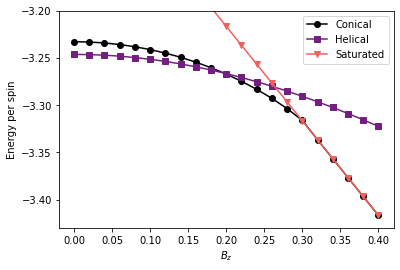

In [6]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data['one_dim_mod_kc-5e-2_HYST'][:, 0],
         data['one_dim_mod_kc-5e-2_HYST'][:, 1] / 30 ** 3, 'o-',
         color=colors[0], label='Conical')
plt.plot(data['helix-y_kc-5e-2_L10'][:, 0], 
         data['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
         color=colors[1], label='Helical')
plt.plot(data['saturated'][:, 0], 
         data['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[2], label='Saturated')
# plt.ylim(-92200, -87000)
plt.ylim(-3.43, -3.2)

plt.ylabel('Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

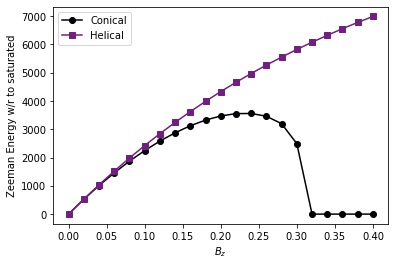

In [16]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data_zeeman['one_dim_mod_kc-5e-2_HYST'][:, 0],
         data_zeeman['one_dim_mod_kc-5e-2_HYST'][:, 1] - data_zeeman['saturated'][:, 1], 'o-',
         color=colors[0], label='Conical')
plt.plot(data_zeeman['helix-y_kc-5e-2_L10'][:, 0], 
         data_zeeman['helix-y_kc-5e-2_L10'][:, 1] - data_zeeman['saturated'][:, 1], 's-',
         color=colors[1], label='Helical')

plt.ylabel('Zeeman Energy w/r to saturated')
plt.xlabel(r'$B_{z}$')

plt.legend()

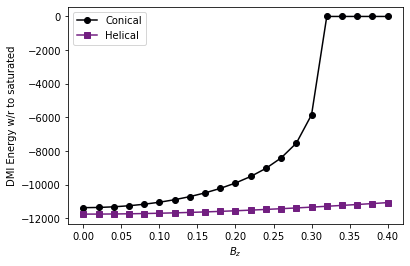

In [18]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data_dmi['one_dim_mod_kc-5e-2_HYST'][:, 0],
         data_dmi['one_dim_mod_kc-5e-2_HYST'][:, 1] - data_dmi['saturated'][:, 1], 'o-',
         color=colors[0], label='Conical')
plt.plot(data_dmi['helix-y_kc-5e-2_L10'][:, 0], 
         data_dmi['helix-y_kc-5e-2_L10'][:, 1] - data_dmi['saturated'][:, 1], 's-',
         color=colors[1], label='Helical')

plt.ylabel('DMI Energy w/r to saturated')
plt.xlabel(r'$B_{z}$')

plt.legend()

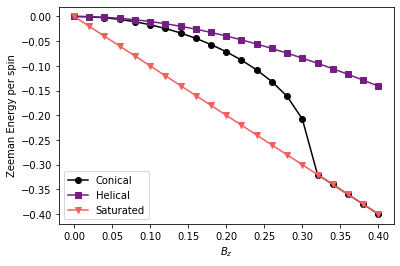

In [14]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data_zeeman['one_dim_mod_kc-5e-2_HYST'][:, 0],
         data_zeeman['one_dim_mod_kc-5e-2_HYST'][:, 1] / 30 ** 3, 'o-',
         color=colors[0], label='Conical')
plt.plot(data_zeeman['helix-y_kc-5e-2_L10'][:, 0], 
         data_zeeman['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
         color=colors[1], label='Helical')
plt.plot(data_zeeman['saturated'][:, 0], 
         data_zeeman['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[2], label='Saturated')
# plt.ylim(-92200, -87000)
# plt.ylim(-3.43, -3.2)

plt.ylabel('Zeeman Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

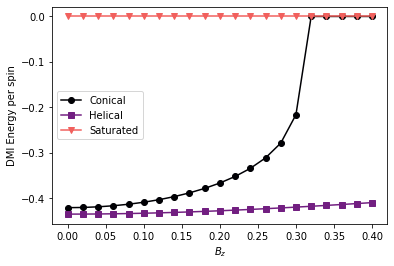

In [15]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data_dmi['one_dim_mod_kc-5e-2_HYST'][:, 0],
         data_dmi['one_dim_mod_kc-5e-2_HYST'][:, 1] / 30 ** 3, 'o-',
         color=colors[0], label='Conical')
plt.plot(data_dmi['helix-y_kc-5e-2_L10'][:, 0], 
         data_dmi['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
         color=colors[1], label='Helical')
plt.plot(data_dmi['saturated'][:, 0], 
         data_dmi['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[2], label='Saturated')
# plt.ylim(-92200, -87000)
# plt.ylim(-3.43, -3.2)

plt.ylabel('DMI Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

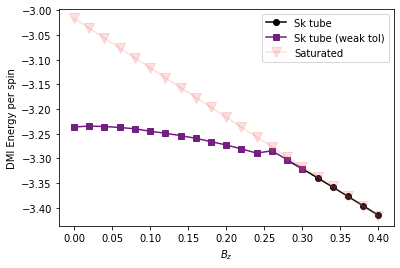

In [32]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data['sk_tube_kc-5e-2'][:, 0],
         data['sk_tube_kc-5e-2'][:, 1] / 30 ** 3, 'o-',
         color=colors[0], label='Sk tube')
# plt.plot(data['sk_tube_kc-5e-2_SAT'][:, 0],
#          data['sk_tube_kc-5e-2_SAT'][:, 1] / 30 ** 3, 'o-',
#          color=colors[1], label='Sk tube (weak tol)')
plt.plot(data['sk_tube_kc-5e-2_WEAK'][:, 0],
         data['sk_tube_kc-5e-2_WEAK'][:, 1] / 30 ** 3, 's-',
         color=colors[1], label='Sk tube (weak tol)')
plt.plot(data['saturated'][:, 0], 
         data['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[2], label='Saturated', alpha=0.2, ms=10)

plt.ylabel('DMI Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

## Energy from helical states

In [22]:
# Using {data} dic from before
for state in ['sk_helix', 'sk_helix_HYST']:
    data[state] = []
    data_dmi[state] = []
    data_zeeman[state] = []
    
    for Bz in np.linspace(0, 200, 11):
        
        try:
            m_state = np.load('sims/fidimag/equilibrium_states/cubic_anisotropy/helix_frankestein/npys/{0}/'
                              'm_{0}_Bz_{1:06d}.npy'.format(state, int(Bz)))
        except:
            continue
        sim.set_m(m_state)
        
        # Update Zeeman field
        Zeeman_int = sim.get_interaction('Zeeman')
        Zeeman_int.update_field((0.0, 0.0, Bz * 1e-3))
        DMI_int = sim.get_interaction('DMI')
        
        # Compute energy
        energy = sim.compute_energy() # - sat_data[Bz]
        
        data[state].append([Bz * 1e-3, energy])
        data_dmi[state].append([Bz * 1e-3, Zeeman_int.compute_energy()])
        data_zeeman[state].append([Bz * 1e-3, DMI_int.compute_energy()])
            
    data[state] = np.array(data[state])
    data_dmi[state] = np.array(data_dmi[state])
    data_zeeman[state] = np.array(data_zeeman[state])

In [2]:
!ls sims/fidimag/equilibrium_states/cubic_anisotropy/helix_frankestein/npys/sk_helix/

m_sk_helix_Bz_000000.npy  m_sk_helix_Bz_000080.npy  m_sk_helix_Bz_000160.npy
m_sk_helix_Bz_000020.npy  m_sk_helix_Bz_000100.npy  m_sk_helix_Bz_000180.npy
m_sk_helix_Bz_000040.npy  m_sk_helix_Bz_000120.npy  m_sk_helix_Bz_000200.npy
m_sk_helix_Bz_000060.npy  m_sk_helix_Bz_000140.npy  m_sk_helix_Bz_000300.npy


(-3.28, -3.24)

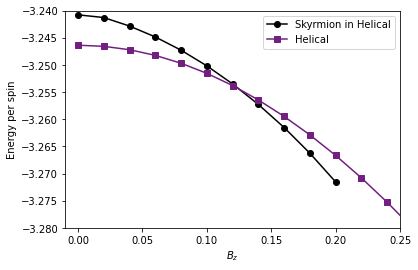

In [61]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data['sk_helix'][:, 0],
         data['sk_helix'][:, 1] / 30 ** 3, 'o-',
         color=colors[0], label='Skyrmion in Helical')
plt.plot(data['helix-y_kc-5e-2_L10'][:, 0], 
         data['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
         color=colors[1], label='Helical')
# plt.plot(data['saturated'][:, 0], 
#          data['saturated'][:, 1] / 30 ** 3, 'v-',
#          color=colors[2], label='Saturated')

plt.ylabel('Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()
plt.xlim(-0.01, 0.25)
plt.ylim(-3.28, -3.24)

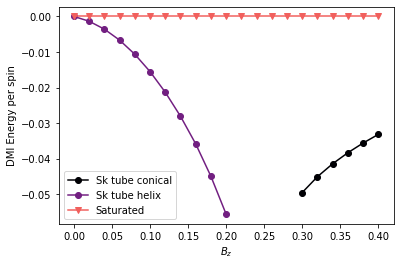

In [26]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data_dmi['sk_tube_kc-5e-2'][:, 0][1:],
         data_dmi['sk_tube_kc-5e-2'][:, 1][1:] / 30 ** 3, 'o-',
         color=colors[0], label='Sk tube conical')
plt.plot(data_dmi['sk_helix'][:, 0],
         data_dmi['sk_helix'][:, 1] / 30 ** 3, 'o-',
         color=colors[1], label='Sk tube helix')
plt.plot(data_dmi['saturated'][:, 0], 
         data_dmi['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[2], label='Saturated')

plt.ylabel('DMI Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

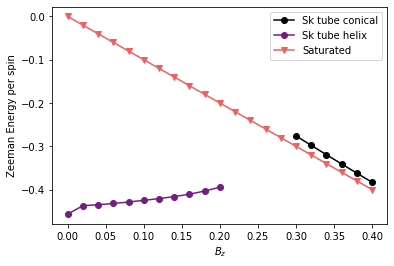

In [27]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data_zeeman['sk_tube_kc-5e-2'][:, 0][1:],
         data_zeeman['sk_tube_kc-5e-2'][:, 1][1:] / 30 ** 3, 'o-',
         color=colors[0], label='Sk tube conical')
plt.plot(data_zeeman['sk_helix'][:, 0],
         data_zeeman['sk_helix'][:, 1] / 30 ** 3, 'o-',
         color=colors[1], label='Sk tube helix')
plt.plot(data_zeeman['saturated'][:, 0], 
         data_zeeman['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[2], label='Saturated')

plt.ylabel('Zeeman Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

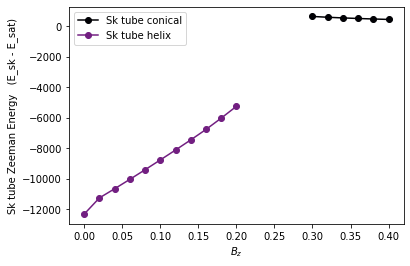

In [36]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

idxs = np.searchsorted(data_zeeman['saturated'][:, 0],
                      data_zeeman['sk_tube_kc-5e-2'][:, 0])
plt.plot(data_zeeman['sk_tube_kc-5e-2'][:, 0][1:],
         data_zeeman['sk_tube_kc-5e-2'][:, 1][1:] - data_zeeman['saturated'][:, 1][idxs][1:], 'o-',
         color=colors[0], label='Sk tube conical')
idxs = np.searchsorted(data_zeeman['saturated'][:, 0],
                       data_zeeman['sk_helix'][:, 0])
plt.plot(data_zeeman['sk_helix'][:, 0],
         data_zeeman['sk_helix'][:, 1] - data_zeeman['saturated'][:, 1][idxs], 'o-',
         color=colors[1], label='Sk tube helix')

plt.ylabel('Sk tube Zeeman Energy   (E_sk - E_sat)')
plt.xlabel(r'$B_{z}$')

plt.legend()

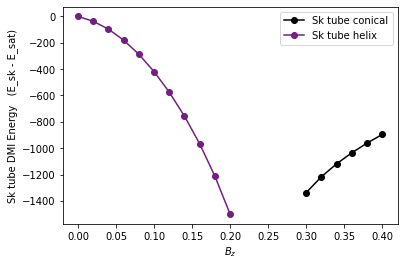

In [37]:
colors = plt.cm.magma(np.linspace(0, 1, 4))

idxs = np.searchsorted(data_dmi['saturated'][:, 0],
                      data_dmi['sk_tube_kc-5e-2'][:, 0])
plt.plot(data_dmi['sk_tube_kc-5e-2'][:, 0][1:],
         data_dmi['sk_tube_kc-5e-2'][:, 1][1:] - data_dmi['saturated'][:, 1][idxs][1:], 'o-',
         color=colors[0], label='Sk tube conical')
idxs = np.searchsorted(data_dmi['saturated'][:, 0],
                       data_dmi['sk_helix'][:, 0])
plt.plot(data_dmi['sk_helix'][:, 0],
         data_dmi['sk_helix'][:, 1] - data_dmi['saturated'][:, 1][idxs], 'o-',
         color=colors[1], label='Sk tube helix')

plt.ylabel('Sk tube DMI Energy   (E_sk - E_sat)')
plt.xlabel(r'$B_{z}$')

plt.legend()

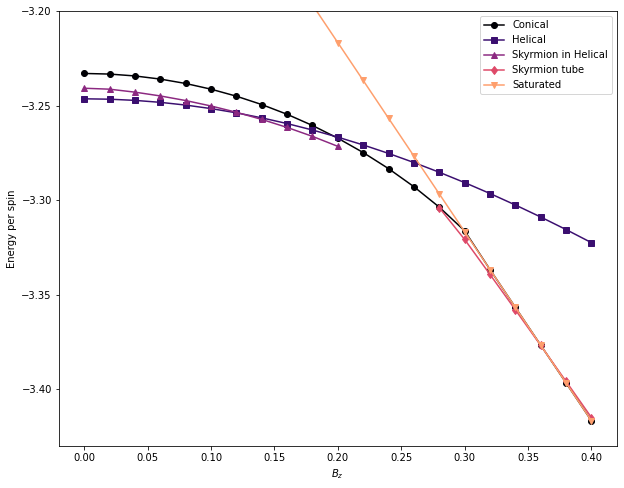

In [33]:
f, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.magma(np.linspace(0, 1, 6))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data['one_dim_mod_kc-5e-2_HYST'][:, 0],
         data['one_dim_mod_kc-5e-2_HYST'][:, 1] / 30 ** 3, 'o-',
         color=colors[0], label='Conical')
plt.plot(data['helix-y_kc-5e-2_L10'][:, 0], 
         data['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
         color=colors[1], label='Helical')
plt.plot(data['sk_helix'][:, 0],
         data['sk_helix'][:, 1] / 30 ** 3, '^-',
         color=colors[2], label='Skyrmion in Helical')
plt.plot(data['sk_tube_kc-5e-2'][:, 0],
         data['sk_tube_kc-5e-2'][:, 1] / 30 ** 3, 'd-',
         color=colors[3], label='Skyrmion tube')
plt.plot(data['saturated'][:, 0], 
         data['saturated'][:, 1] / 30 ** 3, 'v-',
         color=colors[4], label='Saturated')
# plt.ylim(-92200, -87000)
plt.ylim(-3.43, -3.2)

plt.ylabel('Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

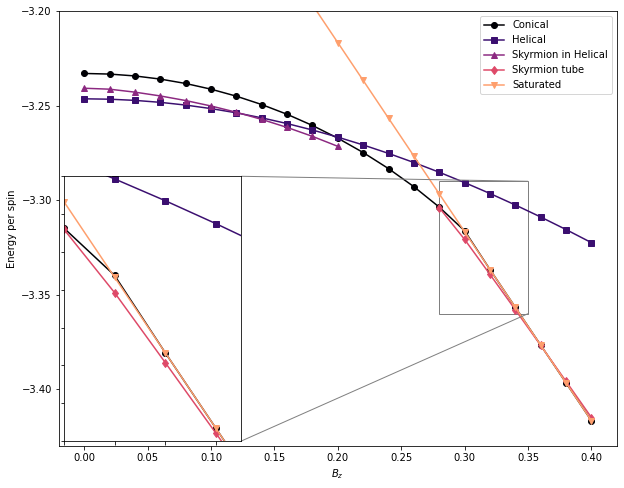

In [34]:
f, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.magma(np.linspace(0, 1, 6))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
ax.plot(data['one_dim_mod_kc-5e-2_HYST'][:, 0],
        data['one_dim_mod_kc-5e-2_HYST'][:, 1] / 30 ** 3, 'o-',
        color=colors[0], label='Conical')
ax.plot(data['helix-y_kc-5e-2_L10'][:, 0], 
        data['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
        color=colors[1], label='Helical')
ax.plot(data['sk_helix'][:, 0],
        data['sk_helix'][:, 1] / 30 ** 3, '^-',
        color=colors[2], label='Skyrmion in Helical')
ax.plot(data['sk_tube_kc-5e-2'][:, 0],
        data['sk_tube_kc-5e-2'][:, 1] / 30 ** 3, 'd-',
        color=colors[3], label='Skyrmion tube')
ax.plot(data['saturated'][:, 0], 
        data['saturated'][:, 1] / 30 ** 3, 'v-',
        color=colors[4], label='Saturated')
# plt.ylim(-92200, -87000)
plt.ylim(-3.43, -3.2)

plt.ylabel('Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

axins = zoomed_inset_axes(ax, 2, loc=3)
axins.plot(data['one_dim_mod_kc-5e-2_HYST'][:, 0],
           data['one_dim_mod_kc-5e-2_HYST'][:, 1] / 30 ** 3, 'o-',
           color=colors[0], label='Conical')
axins.plot(data['helix-y_kc-5e-2_L10'][:, 0], 
           data['helix-y_kc-5e-2_L10'][:, 1] / 30 ** 3, 's-',
           color=colors[1], label='Helical')
axins.plot(data['sk_helix'][:, 0],
           data['sk_helix'][:, 1] / 30 ** 3, '^-',
           color=colors[2], label='Skyrmion in Helical')
axins.plot(data['sk_tube_kc-5e-2'][:, 0],
           data['sk_tube_kc-5e-2'][:, 1] / 30 ** 3, 'd-',
           color=colors[3], label='Skyrmion tube')
axins.plot(data['saturated'][:, 0], 
           data['saturated'][:, 1] / 30 ** 3, 'v-',
           color=colors[4], label='Saturated')
axins.set_xlim(0.28, 0.35)
axins.set_ylim(-3.36, -3.29)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=4, loc2=1, fc="none", ec="0.5")

plt.savefig('States_energies.pdf', bbox_inches='tight')

In [36]:
import os

In [37]:
os.mkdir('energy_txts')

states = ['one_dim_mod_kc-5e-2_HYST',
          'helix-y_kc-5e-2_L10',
          'sk_helix',
          'sk_tube_kc-5e-2',
          'saturated']

for st in states:
    np.savetxt('energy_txts/' + st + 'ENERGY.txt', data[st])

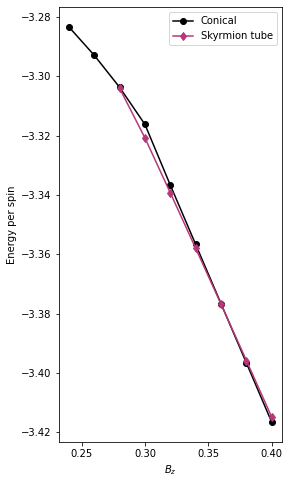

In [76]:
f, ax = plt.subplots(figsize=(4, 8))

colors = plt.cm.magma(np.linspace(0, 1, 3))

# plt.plot(data['one_dim_mod_kc-5e-2'][:, 0], data['one_dim_mod_kc-5e-2'][:, 1], 'o-')
plt.plot(data['one_dim_mod_kc-5e-2_HYST'][:, 0][12:],
         data['one_dim_mod_kc-5e-2_HYST'][:, 1][12:] / 30 ** 3, 'o-',
         color=colors[0], label='Conical')
plt.plot(data['sk_tube_kc-5e-2'][:, 0][2:],
         data['sk_tube_kc-5e-2'][:, 1][2:] / 30 ** 3, 'd-',
         color=colors[1], label='Skyrmion tube')
# plt.ylim(-3.43, -3.2)

plt.ylabel('Energy per spin')
plt.xlabel(r'$B_{z}$')

plt.legend()

# Energies without anisotropy

In [7]:
FIELD = 100
nx, ny, nz = 30, 30, 30
dx, dy, dz = 1, 1, 1
mesh = CuboidMesh(nx=nx, ny=ny, nz=nz,
                  dx=dx, dy=dy, dz=dz,
                  x0=-nx * 0.5, y0=-ny * 0.5, z0=-nz * 0.5,
                  unit_length=1.,
                  periodicity=(True, True, False)
                  )

sim_name = 'sk_helix'
sim = Sim(mesh, name=sim_name, integrator='sundials_openmp')

sim.mu_s = 1
sim.add(fd.atomistic.Exchange(1))
sim.add(fd.atomistic.DMI(0.727, dmi_type='bulk'))
bz_min = FIELD
sim.add(fd.atomistic.Zeeman((0.0, 0.0, bz_min * 1e-3)), save_field=True)
    
x, y, z = mesh.coordinates[:, 0], mesh.coordinates[:, 1], mesh.coordinates[:, 2]
xs, ys, zs = np.unique(x), np.unique(y), np.unique(z)

Number of threads (CVODE) = 8


In [38]:
np.linspace(320, 500, 10)

array([320., 340., 360., 380., 400., 420., 440., 460., 480., 500.])

In [28]:
data = {}

for state in ['one_dim_mod',
              'saturated', 'sk_tube',
              # 'two_bobbers_long',  'two_bobbers_med', 'two_bobbers_short', 
              # 'one_bobber_long', 'one_bobber_short'
              ]:
    data[state] = []
    
    for Bz in np.linspace(300, 500, 11):
        
        if state == 'saturated':
            m_state = (0, 0, 1)
        elif state == 'sk_tube' and Bz < 280:
            continue
        else:
            try:
                m_state = np.load('sims/fidimag/equilibrium_states/D727e-3/npys/{0}/'
                                  'm_{0}_Bz_{1:06d}.npy'.format(state, int(Bz)))
            except:
                continue

        sim.set_m(m_state)
        
        # Update Zeeman field
        Zeeman_int = sim.get_interaction('Zeeman')
        Zeeman_int.update_field((0.0, 0.0, Bz * 1e-3))

        # Compute energy
        energy = sim.compute_energy() # - sat_data[Bz]
        
        data[state].append([Bz * 1e-3, energy])
        
    data[state] = np.array(data[state])

In [29]:
data

{'one_dim_mod': array([[ 3.00000000e-01, -8.89432305e+04],
        [ 3.20000000e-01, -8.93102663e+04],
        [ 3.40000000e-01, -8.97005461e+04],
        [ 3.60000000e-01, -9.01139599e+04],
        [ 3.80000000e-01, -9.05503701e+04],
        [ 4.00000000e-01, -9.10095946e+04],
        [ 4.20000000e-01, -9.14913720e+04],
        [ 4.40000000e-01, -9.19952815e+04],
        [ 4.60000000e-01, -9.25205279e+04],
        [ 4.80000000e-01, -9.30600000e+04],
        [ 5.00000000e-01, -9.36000000e+04]]),
 'saturated': array([[ 3.000e-01, -8.820e+04],
        [ 3.200e-01, -8.874e+04],
        [ 3.400e-01, -8.928e+04],
        [ 3.600e-01, -8.982e+04],
        [ 3.800e-01, -9.036e+04],
        [ 4.000e-01, -9.090e+04],
        [ 4.200e-01, -9.144e+04],
        [ 4.400e-01, -9.198e+04],
        [ 4.600e-01, -9.252e+04],
        [ 4.800e-01, -9.306e+04],
        [ 5.000e-01, -9.360e+04]]),
 'sk_tube': array([[ 3.00000000e-01, -8.89455790e+04],
        [ 3.20000000e-01, -8.93059564e+04],
        [ 3

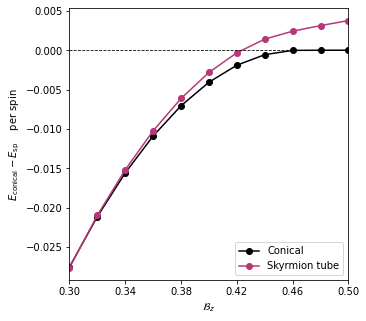

In [36]:
f, ax = plt.subplots(figsize=(5, 5))

colors = plt.cm.magma(np.linspace(0, 1, 3))

plt.plot(data['one_dim_mod'][:, 0],
         (data['one_dim_mod'][:, 1] - data['saturated'][:, 1]) / 30 ** 3, 'o-',
         color=colors[0], label='Conical')

plt.plot(data['sk_tube'][:, 0],
         (data['sk_tube'][:, 1] - data['saturated'][:, 1]) / 30 ** 3, 'o-',
         color=colors[1], label='Skyrmion tube')

plt.axhline(y=0, lw=0.8, ls='--', color='k')
plt.xticks(np.arange(300e-3, 501e-3, 40e-3))

# plt.ylim(-3.43, -3.2)
plt.xlim(0.3, 0.5)

plt.ylabel('$E_{\mathrm{conical}}-E_{\mathrm{sp}}$    per spin')
plt.xlabel(r'$\mathcal{B}_{z}$')

plt.gca().legend(loc=4)

plt.savefig('energy_conical_no-anis.pdf', bbox_inches='tight')

In [41]:
(data['one_dim_mod'][:, 1] - data['saturated'][:, 1])

array([-5.70266331e+02, -4.20546070e+02, -2.93959859e+02, -1.90370099e+02,
       -1.09594583e+02, -5.13719607e+01, -1.52814721e+01, -5.27861116e-01,
        9.76331648e-07,  5.21977199e-07])

In [38]:
from pathlib import Path

In [39]:
savedir = Path('energy_txts')

states = ['one_dim_mod',
          'sk_tube',
          'saturated']

for st in states:
    np.savetxt(savedir / f'{st}_no-anis_ENERGY.txt', data[st])